This example reads continuously the phase at a fixed frequency, near the resonator location. It then creates a trigger that causes the resonator to move. It will show as a phase jump followed by a recovery given by the resonator sweep time.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('soft/')

from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm

In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('./qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU208

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	6 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_sg_mux4_v1 - tProc output 6, envelope memory 0 samples
		DAC tile 0, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz

	8 readout channels:
	0:	axis_pf

In [3]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

In [21]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()

# Enable resonator.
simu.enable(499.3, t=125, N=1)
# simu.enable(499.3)
#simu.enable(503)
#simu.enable(800)
#simu.enable(1105)

#simu.disable(595)
#simu.disable(600)
#simu.disable(605)

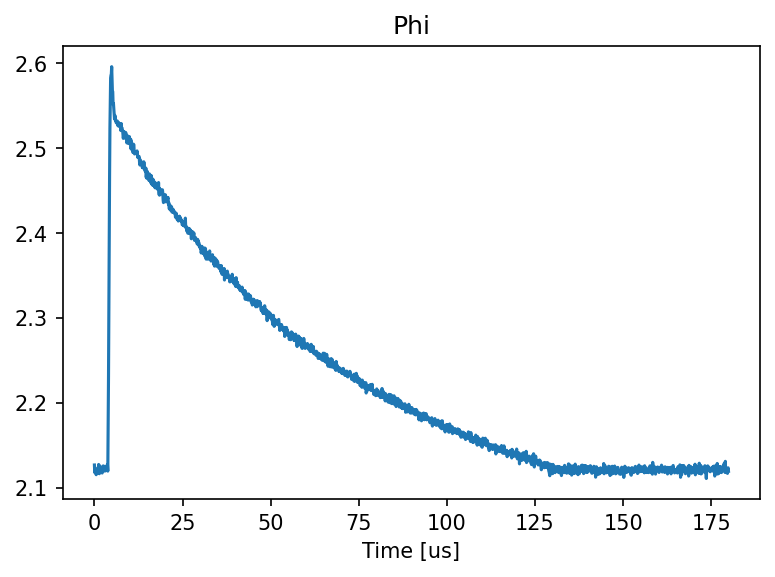

In [22]:
class PhaseFastProgram(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(0.7*self.cfg['period'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],                             
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="periodic")
        
        # Write conditional register.
        self.regwi(0,2,self.cfg['cond_jump'],"Conditional Jump")
        
        # Send pulse out.
        self.pulse(ch=self.cfg["gen_ch"])
        
        # Sync.
        self.synci(self.us2cycles(self.cfg['wait_start']))
    
    def body(self):

        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'!=',15,'JUMP')
        self.trigger(pins=[12,13,14,15,16,17,18,19]) # play readout pulse
        self.label('JUMP')
        
        self.trigger(adcs=self.ro_chs, pins=[0])                
        self.synci(self.us2cycles(self.cfg['period']))
        
config={"gen_ch"      : 4,
        "ro_ch"       : 4,
        "reps"        : 1800,
        "pulse_length": 10,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 498, # [MHz]
        "cond_jump"   : 10,
        "period"      : 0.1,
        "wait_start"  : 20
       }

prog = PhaseFastProgram(soccfg, config)
prog.acquire(soc, progress=False)

# Plot data.
nsamp = prog.ro_chs[config['ro_ch']]['length']
di = prog.di_buf[0]/nsamp
dq = prog.dq_buf[0]/nsamp
diq = di + 1j*dq
a = np.abs(diq)
phi = np.angle(diq)
n = config['period']*np.arange(len(di))

#Plot results.
# plt.figure(dpi=150)
# plt.plot(n,di)
# plt.title("Real Part")

# plt.figure(dpi=150)
# plt.plot(n,dq)
# plt.title("Imaginary Part")

plt.figure(dpi=150)
plt.plot(n,np.unwrap(phi))
plt.xlabel("Time [us]");
plt.title("Phi");

In [23]:
print(prog)


// Program

        regwi 2, $21, 435159040;                //freq = 435159040
        regwi 2, $22, 0;                        //phase = 0
        regwi 2, $24, 8000;                     //gain = 8000
        regwi 2, $25, 855040;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 3072 
        regwi 0, $2, 10;                        //Conditional Jump
        regwi 2, $26, 0;                        //t = 0
        set 4, 2, $21, $22, $0, $24, $25, $26;  //ch = 4, pulse @t = $26
        synci 7000;
        regwi 0, $15, 0;
        regwi 0, $14, 1799;
LOOP_J: condj 0, $2, !=, $15, @JUMP;
        regwi 0, $31, 1044480;                  //out = 0b11111111000000000000
        seti 7, 0, $31, 0;                      //ch =0 out = $31 @t = 0
        seti 7, 0, $0, 10;                      //ch =0 out = 0 @t = 0
JUMP:   regwi 0, $31, 257;                      //out = 0b0000000100000001
        seti 7, 0, $31, 270;                    //ch =0 out = $31 @t = 0
        set